## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [10]:
import os
import pandas as pd
import numpy as np
import math


import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.patches import Patch

import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

from keras import layers
from keras.utils.np_utils  import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

# import visualkeras

import cv2
from typing import Tuple
from tqdm import tqdm
from PIL import Image

from model2D import *
from model3D_small import *
from Imports.visualize import *
from Imports.extraction import *


##### Data Description

In [11]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [12]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col = meta_data["label"].to_list()
paths_col = meta_data.index.to_list()

print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


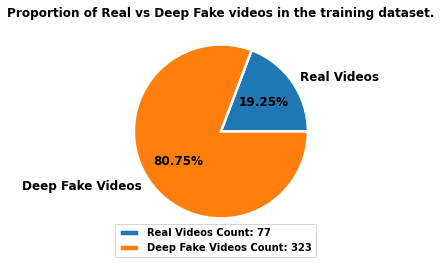

In [13]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

## Frames

In [14]:
training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []

for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
    
complete_paths.sort()

In [ ]:
(faces, indices) = get_faces(complete_paths, 5)

In [ ]:
print_face_features(faces, indices)

## Frames

In [ ]:
weights = 'imagenet'
include_top = False
pooling = 'avg'

model = ResNet50(weights, include_top, pooling)

In [ ]:
paths = complete_paths
frames_each_video = 5 
video_amount = 200

video_array_colors, face_regions = get_frames_v2(paths, frames_each_video, video_amount)

In [ ]:
video_features = extract_features(face_regions, model)

In [ ]:
print(vid_arr_col.shape)
print(vid_arr_col[8].shape)

In [34]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)
np.delete(y, indices)
y = to_categorical(y, num_classes=None).astype(int)
y[:10]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

### Plot frames

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [ ]:
video_features, face_regions = extract_features_v2(vid_arr_col)

In [ ]:
tsne = TSNE(n_components=2, random_state=42,perplexity=20)
tsne_results = tsne.fit_transform(video_features)

In [ ]:
vis = visualkeras.layered_view(test_m, to_file="images/layers_yo.png", legend=True)
vis.show()
plt.rcParams.update({'font.size':500})  # set the legend font size to 56
plt.show()

In [ ]:
plot_model(test_m, to_file="images/layerv2.png", show_shapes = True, show_layer_names = True)

In [ ]:
plot_tsne_with_images(tsne_results, face_regions)

In [41]:

# Generate some example data
data = np.random.rand(10, 10)

fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.imshow(data, cmap='viridis')

# Create the colorbar
cbar = fig.colorbar(heatmap, ax=ax)

# Change the font size of the colorbar labels
cbar.ax.tick_params(labelsize=14)  # You can set the desired font size here

# Show the plot
plt.show()


In [ ]:
plot_faces(face_regions, figsize=(10, 10), width=5, height=4)

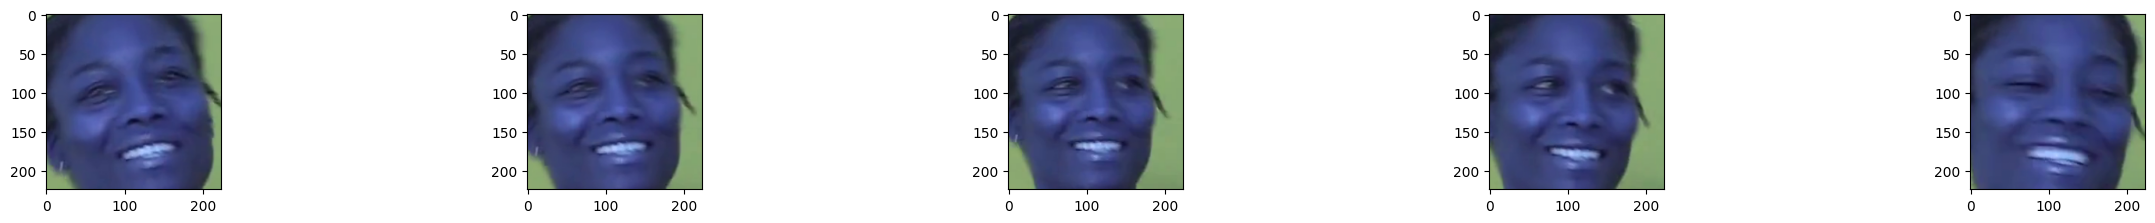

In [48]:
plot_video(faces[2], (30,5), 2, 5)

## tSNE

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [35]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

{0: 2.5974025974025974, 1: 0.6191950464396285}

In [36]:
def build_3D_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu", input_shape=input_data.shape[1:]))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=32, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=16, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Conv3D(filters=8, kernel_size=3, padding="same", activation="relu"))
    model.add(layers.MaxPool3D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(2 ,activation="softmax"))
    return model


In [37]:
def test_model(input_data):
    model = keras.models.Sequential()
    model.add(layers.Conv3D(filters=32, kernel_size=(2,2,2),input_shape=input_data.shape[1:],
                activation='relu',
                padding='same', data_format='channels_last'))
    model.add(layers.BatchNormalization())
    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))

    model.add(layers.ConvLSTM2D(filters=16, kernel_size=(2, 2),
                    padding='same', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.MaxPooling3D(pool_size=(2,2,2)))
    model.add(layers.Flatten())

    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32,activation='elu'))

    model.add(layers.Dense(2,activation='sigmoid'))
    return model

In [38]:
test_m = test_model(faces)
test_m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 5, 224, 224, 32)   800       
                                                                 
 batch_normalization (BatchN  (None, 5, 224, 224, 32)  128       
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 5, 224, 224, 16)   12352     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 224, 224, 16)  64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 5, 224, 224, 16)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 112, 112, 16)  0

In [39]:
loss = "binary_crossentropy"
optimizer = "adam"
metrics=["accuracy"]
test_m.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [40]:
history_test = test_m.fit(faces, 
                          y[:faces.shape[0]],
                          epochs=10, 
                          batch_size=10, 
                          verbose=1, 
                          class_weight=class_weights)

2023-04-18 10:52:26.516402: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67737600 exceeds 10% of free system memory.


Epoch 1/10


2023-04-18 10:52:34.212867: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321126400 exceeds 10% of free system memory.
2023-04-18 10:52:34.213153: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321126400 exceeds 10% of free system memory.
2023-04-18 10:52:34.529228: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.
2023-04-18 10:52:34.721929: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64225280 exceeds 10% of free system memory.


9/9 [==============================] - 152s 15s/step - loss: 10.4594 - accuracy: 0.6000
Epoch 2/10
9/9 [==============================] - 154s 17s/step - loss: 4.8755 - accuracy: 0.7333
Epoch 3/10
9/9 [==============================] - 152s 17s/step - loss: 7.1102 - accuracy: 0.7000
Epoch 4/10
9/9 [==============================] - 153s 17s/step - loss: 10.0010 - accuracy: 0.6444
Epoch 5/10
3/9 [=========>....................] - ETA: 1:44 - loss: 1.5069 - accuracy: 0.6667

KeyboardInterrupt: 

In [ ]:
pred_y = test_m.predict(vid_arr_col)

In [ ]:
pred_y[:5]

In [ ]:
actual_y = np.argmax(y[:vid_arr_col.shape[0]], axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))

In [ ]:
pred_y.sum()

In [ ]:
actual_y

In [ ]:
cfm = confusion_matrix(actual_y, pred_y)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()

In [ ]:
model_3D_col = build_3D_model(vid_arr_col)
model_3D_col.summary()

In [ ]:
loss = "binary_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model_3D_col.fit(vid_arr_col, 
                           y[:vid_arr_col.shape[0]],
                           epochs=10, 
                           batch_size=10, 
                           verbose=2)

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]
model_3D_col.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Plotting performance

In [ ]:
print(history_test.params)
print(history_test.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history_test.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_test.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()